# Toy Model of an EFT --- Mini-Project

### Alexandra Semposki

#### Started: 13 November 2020

In this project, we attempt to extract the coefficients of the Taylor expansion of an EFT model. Shown below is the original function in the theory:

$$
g(x) = \left(\frac{1}{2} + \tan \left(\frac{\pi x}{2} \right) \right)^{2}
$$

which possesses the Taylor expansion

$$
g(x) = 0.25 + 1.57x + 2.47x^{2} + 1.29x^{3} + \dots
$$

We will call the theory model for this situation as as the equation below:

$$
g_{th}(x) = \sum_{n=0}^{k} a_{n}x^{n}
$$

where $k$ represents the highest order we will go to in our polynomial fit. 

The first step is to generate some data from this model to use in our fitting process. This is done below. We need to remember that, when generating this synthetic data, we introduce a 5% error into each point, so that it looks more like the experimental data we'd be obtaining in the lab. This relation is given by (Eq. (2) in the paper):

$$
d_{j} = g(x_{j})(1+c\eta_{j})
$$

where $\eta$ is a normal distribution of mean 0 and standard deviation 1. $c$ is the relative error, 0.05 in this case. The error bars on each data point are constructed using

$$
\sigma_{j} = cd_{j}
$$

and are shown on the plot below.

<ErrorbarContainer object of 3 artists>

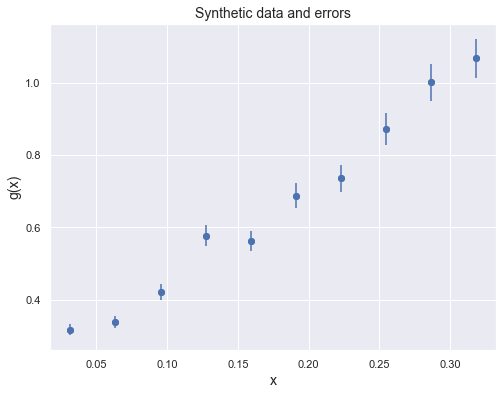

In [1]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

#import emcee
import emcee

#My original sampled function is below
'''
#define the function we are extracting data from 
def model(x):
    return (0.5 + np.tan(np.pi*x/2))**2.0 

#define a step size for the x values 
h = (1.0/np.pi - 0.0)/10

#define the range of x values needed, excluding zero
x = np.arange(0.0 + h, 1.0/np.pi + h, h)

#generate the array of data for the initial values
data1 = model(x)

#introduce the 5% error 
rand = np.random.RandomState()
data = data1 + 0.05*rand.randn(10)

#calculate some error bars
sig = 0.05*data

'''

#Schindler-Phillips data set implemented below
x = 2.0/np.pi * np.array([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
data = np.array([0.31694, 0.33844, 0.42142, 0.57709, 0.56218, 0.68851, 0.73625, 0.87280, 1.0015, 1.0684])
sig = np.array([0.01585, 0.01692, 0.02107, 0.02885, 0.02811, 0.03443, 0.03681, 0.04364, 0.0501, 0.0534])

fig = plt.figure(figsize=(8,6))
plt.xlabel('x', fontsize = 14)
plt.ylabel('g(x)', fontsize = 14)
plt.title('Synthetic data and errors', fontsize = 14)
plt.plot(x, data, 'bo')
plt.errorbar(x, data, sig, fmt='o')

Now that this has been done, we need to start building the priors and the likelihood to go into Bayes' Theorem. Bayes' Theorem reads simply here as:

$$
pr(a|D,I) = \frac{pr(D|a,I) pr(a|I)}{pr(D|I)}
$$

where $a$ is the vector of Taylor expansion coefficients we are trying to model, and $D$ is the data we have from the "experiment" we've done above. $I$ is any prior information we have concerning this problem/experiment.

There are two priors we would like to test: uniform and Gaussian. These are below:

$$
pr(a|\bar{a},I) = 1 
$$
and
$$
pr(a|\bar{a},I) = \left(\frac{1}{\sqrt{2\pi}\bar{a}}\right)^{k+1} \exp\left(-\frac{a^{2}}{2\bar{a}^{2}}\right)
$$

where $\bar{a}$ is a parameter to be determined later, and referred to as 'afix' in the code.

The likelihood function is also needed for this project. It is given as:

$$
pr(D|a,I) = \prod_{j=1}^{N_{d}} \left(\frac{1}{\sqrt{2\pi} \sigma_{j,exp}}\right) \exp\left(-\frac{\chi^{2}}{2}\right)
$$

where the chi-squared term is given as

$$
\chi^{2} = \sum_{i=1}^{N_{d}} \left(\frac{d_{i} - g_{th}(x_{i})}{\sigma_{i}}\right)^{2}
$$

where $d_{i}$ is the data and $g_{th}(x_{i})$ is the prediction we get at $x_{i}$ from EFT using the polynomial expansion, and $\sigma_{i}$ are the errors we obtained previously.

Let's try to write these into functions we can call for the emcee sampler later on.

In [2]:
#introduce the uniform prior (log(1) = 0)
def log_uniform(a):
    
    if np.all(np.abs(a) < 1000):
        return 0
    
    else:
        return -np.inf 

#introduce the gaussian prior
def log_gaussprior(a, k):
    afix = 5.0
    pre = -(k + 1) * np.log(np.sqrt(2.0 * np.pi)*afix)
    return pre - np.dot(a,a)/(2.0*afix**2.0)

In [3]:
#define the model function
def g_model(a, x, k):

    g = 0.0
    
    for n in range(k+1):
        g += a[n] * (x**n)
        
    return g

#define the likelihood function (log likelihood for calculation efficiency)
def log_likelihood(a, x, data, sig, nd, k):
        
    #calculate the chi-squared
    chisq = 0.0 
    
    for i in range(nd):
        chisq += ((data[i] - g_model(a, x[i], k))/sig[i])**2.0
                
    #finish the function
    f = -0.5 * (np.sum(np.log(2.0 * np.pi * sig**2.0)) + chisq)
        
    return f

Now, after these definitions, we will need to define the posterior with the two different priors.

In [4]:
#define the log posteriors to be used
def log_posterior1(a, x, data, sig, nd, k):
    return log_uniform(a) + log_likelihood(a, x, data, sig, nd, k)

def log_posterior2(a, x, data, sig, nd, k):
    return log_gaussprior(a, k) + log_likelihood(a, x, data, sig, nd, k)

We will also need the function to calculate the auto-correlation of the samples.

In [5]:
def autocorrelation(chain, max_lag=100):
    dimension = len(chain)
    acors = np.empty(max_lag+1)
    if max_lag > len(chain)/5:
        warnings.warn('max_lag is more than one fifth the chain length')
    # Create a copy of the chain with average zero
    chain1d = chain - np.average(chain)
    for lag in range(max_lag+1):
        unshifted = None
        shifted = chain1d[lag:]
        if 0 == lag:
            unshifted = chain1d
        else:
            unshifted = chain1d[:-lag]
        normalization = np.sqrt(np.dot(unshifted, unshifted))
        normalization *= np.sqrt(np.dot(shifted, shifted))
        acors[lag] = np.dot(unshifted, shifted) / normalization
    return acors

Once this is done, we can move on to setting up the emcee sampling procedure. 

In [6]:
#set up the number of parameters we are looking for
ndim = 4
nwalkers = 50 
nsteps = 20000

#number of data points
nd = 10 

#order of the polynomial
k = 3

#dummy number to indicate real value
kreal = 3

print('Using {} walkers with {} steps each.'.format(nwalkers, nsteps))

#initialize the sequence by starting the walkers at a random point
starting_points = np.random.randn(nwalkers, ndim)

Using 50 walkers with 20000 steps each.


In [7]:
#set the sampler for the first posterior (uniform prior)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior1, args=[x, data, sig, nd, k])

#run the sampler and print the wall time
%time sampler.run_mcmc(starting_points, nsteps)
print('Calculation finished!')

Wall time: 1min 17s
Calculation finished!


Now we need to take what this calculation produced and work with it until we can plot it. 

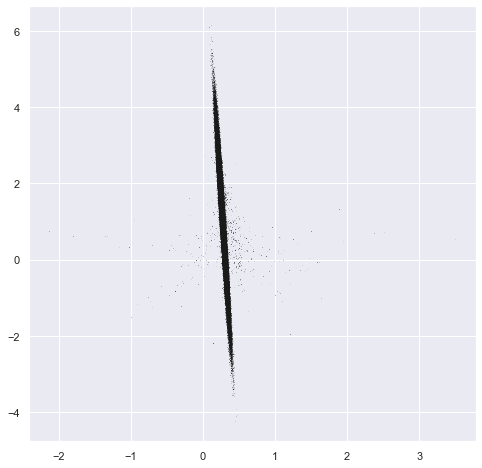

In [8]:
#take the individual walker chains and reshape them into one chain
emcee_trace = sampler.chain[:, :, :].reshape(-1, ndim).T

#plot the result
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(emcee_trace[0], emcee_trace[1], ',k', alpha=0.1);
#ax.hist(emcee_trace[0], bins=200, density=True)

As can be seen, this calculation is, at present, terrible. Let's try to remedy this with burn-in subtracted from the chain.

In [9]:
#create a burnin number of iterations
nburnin = 1000

#throw out the burn-in and reshape again
emcee_trace = sampler.chain[:, nburnin:, :].reshape(-1, ndim).T
emcee_lnprob = sampler.lnprobability[:, nburnin:].reshape(-1).T

Now we try and plot what we got. 

Max posterior is at: [  0.269   0.923   8.459 -10.863]


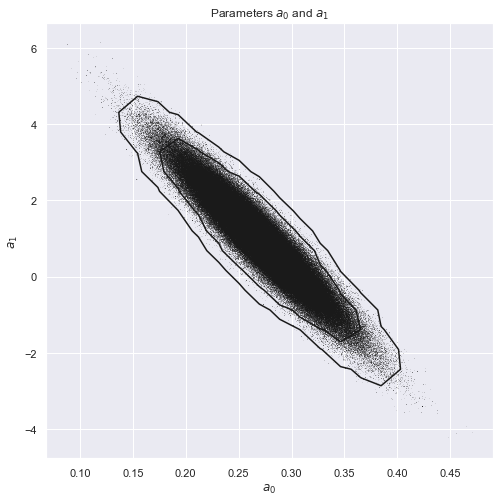

In [10]:
def compute_sigma_level(trace1, trace2, nbins=20):
    """From a set of traces, bin by number of standard deviations"""
    L, xbins, ybins = np.histogram2d(trace1, trace2, nbins)
    L[L == 0] = 1E-16
    logL = np.log(L)

    shape = L.shape
    L = L.ravel()

    # obtain the indices to sort and unsort the flattened array
    i_sort = np.argsort(L)[::-1]
    i_unsort = np.argsort(i_sort)

    L_cumsum = L[i_sort].cumsum()
    L_cumsum /= L_cumsum[-1]
    
    xbins = 0.5 * (xbins[1:] + xbins[:-1])
    ybins = 0.5 * (ybins[1:] + ybins[:-1])

    return xbins, ybins, L_cumsum[i_unsort].reshape(shape)

def plot_MCMC_trace(ax, xdata, ydata, trace, scatter=False, **kwargs):
    """Plot traces and contours"""
    xbins, ybins, sigma = compute_sigma_level(trace[0], trace[1])
    ax.contour(xbins, ybins, sigma.T, levels=[0.683, 0.955, 0.997], **kwargs)
    if scatter:
        ax.plot(trace[0], trace[1], ',k', alpha=0.1)
        ax.set_title(r'Parameters $a_{0}$ and $a_{1}$')
        ax.set_xlabel(r'$a_{0}$')
        ax.set_ylabel(r'$a_{1}$')
    
# Convenience function to extract the peak position of the mode
def max_of_mode(sampler_object):
    max_arg = np.argmax(sampler_object.flatlnprobability)
    return(sampler_object.flatchain[max_arg])
    
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
plot_MCMC_trace(ax, x, data, emcee_trace, scatter=True,colors='k');
max_mode_a=max_of_mode(sampler)
with np.printoptions(precision=3):
    print(f'Max posterior is at: {max_mode_a}')

Now that this is working for two parameters, we can try the corner plot package. Even if we set ndim and k to higher orders, we will be able to only plot the first two values in the contour above, while plotting all parameters using corner. 

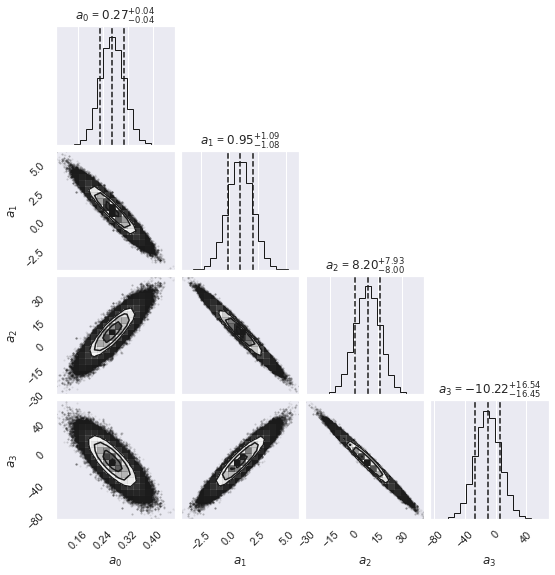

In [11]:
import corner

#use the emcee_trace parameter
fig, ax = plt.subplots(4,4, figsize=(8,8))
corner.corner(emcee_trace.T,labels=[r"$a_{0}$", r"$a_{1}$", r"$a_{2}$", r"$a_{3}$", r"$a_{4}$", r"$a_{5}$", r"$a_{6}$"], quantiles=[0.16, 0.5, 0.84],fig=fig,show_titles=True);

Given this information, we print out the chi-squared per degree of freedom below.

In [12]:
#set up a chi-squared/dof calculation using the original table I calculated
a0 = [0.475]
a1 = [0.20, 2.56]
a2 = [0.25, 1.57, 3.32]
a3 = [0.27, 0.98, 7.95, -9.82]
a4 = [0.327, -1.624, 41.497, -167.795, 242.527]
a5 = [3.667e-01, -3.687e+00, 7.476e+01, -4.001e+02, 9.749e+02, -8.535e+02]
a6 = [3.605e-01, -3.453e+00, 7.223e+01, -3.790e+02, 8.104e+02, -1.918e+02, -9.256e+02]

#initialise all variables
chisq0 = 0.0
chisq1 = 0.0
chisq2 = 0.0
chisq3 = 0.0
chisq4 = 0.0
chisq5 = 0.0
chisq6 = 0.0

#call the g_model function to use with the above values
for i in range(nd):
    chisq0 += ((data[i] - g_model(a0, x[i], 0))/sig[i])**2.0
    chisq1 += ((data[i] - g_model(a1, x[i], 1))/sig[i])**2.0
    chisq2 += ((data[i] - g_model(a2, x[i], 2))/sig[i])**2.0
    chisq3 += ((data[i] - g_model(a3, x[i], 3))/sig[i])**2.0
    chisq4 += ((data[i] - g_model(a4, x[i], 4))/sig[i])**2.0
    chisq5 += ((data[i] - g_model(a5, x[i], 5))/sig[i])**2.0
    chisq6 += ((data[i] - g_model(a6, x[i], 6))/sig[i])**2.0

#define the dof for each case above (data points - parameters)
dof0 = 9
dof1 = 8
dof2 = 7
dof3 = 6
dof4 = 5
dof5 = 4
dof6 = 3 

#calculate the chisq/dof for each case
chidof0 = chisq0/dof0
chidof1 = chisq1/dof1
chidof2 = chisq2/dof2
chidof3 = chisq3/dof3
chidof4 = chisq4/dof4
chidof5 = chisq5/dof5
chidof6 = chisq6/dof6

#print the above results
print("---Chi-squared/dof results---\n k_max = 0: {}\n k_max = 1: {}\n k_max = 2: {}".format(chidof0, chidof1, chidof2))
print(" k_max = 3: {}\n k_max = 4: {}\n k_max = 5: {}\n k_max = 6: {}\n".format(chidof3, chidof4, chidof5, chidof6))

---Chi-squared/dof results---
 k_max = 0: 66.55943153886398
 k_max = 1: 2.247490494161892
 k_max = 2: 1.6419241822173756
 k_max = 3: 1.8569813282593823
 k_max = 4: 1.9592390841506195
 k_max = 5: 2.2229756075167226
 k_max = 6: 2.850372668088113



Next step would be to repeat this calculation for the Gaussian prior. We'll do this below, as we don't want to overwrite our results from the uniform prior. 

In [13]:
#import the emcee sampler package
import emcee

#print the version we are using
print('emcee sampling (version: {})'.format(emcee.__version__))

#set up the number of parameters we are looking for
ndim = 2 #4
nwalkers = 50 
nsteps = 500 #10000 

#number of data points
nd = 10 

#order of the polynomial
k = 1

#dummy number to indicate real value
kreal = 1

print('Using {} walkers with {} steps each.'.format(nwalkers, nsteps))

#initialize the sequence by starting the walkers at a random point
starting_points = np.random.randn(nwalkers, ndim)

#set the sampler for the second posterior (Gaussian prior)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior2, args=[x, data, sig, nd, k])

#run the sampler and print the wall time
%time sampler.run_mcmc(starting_points, nsteps)
print('Calculation finished!')

emcee sampling (version: 3.0.2)
Using 50 walkers with 500 steps each.
Wall time: 1.53 s
Calculation finished!


Now we reshape the chains and plot the first two coefficients to check them.

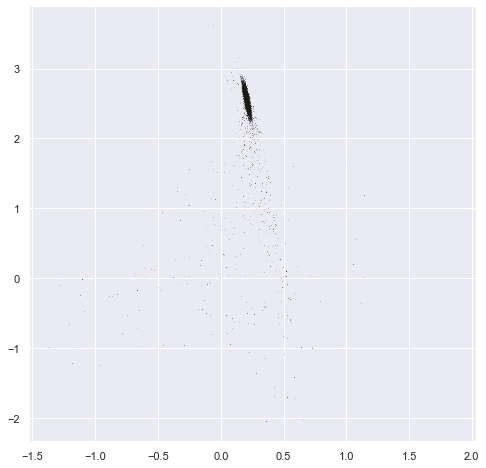

In [14]:
#take the individual walker chains and reshape them into one chain
emcee_trace = sampler.chain[:, :, :].reshape(-1, ndim).T

#plot the result
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(emcee_trace[0], emcee_trace[1], ',k', alpha=0.1);

From here, we cut a number of burn-in iterations from the chains and plot the rest.

In [15]:
#create a burnin number of iterations
nburnin = 100#1000

#throw out the burn-in and reshape again
emcee_trace = sampler.chain[:, nburnin:, :].reshape(-1, ndim).T
emcee_lnprob = sampler.lnprobability[:, nburnin:].reshape(-1).T

Max posterior is at: [0.203 2.552]


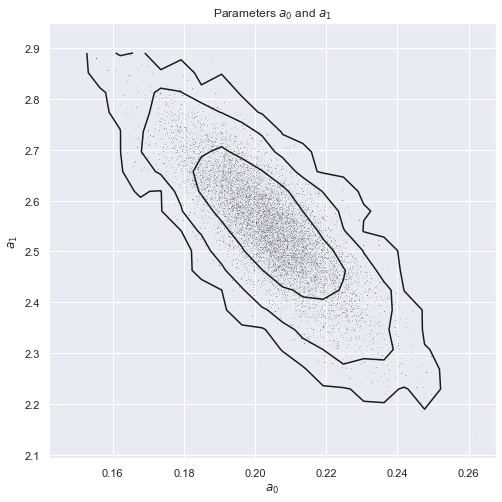

In [16]:
#plot the results using the functions from the uniform prior section
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
plot_MCMC_trace(ax, x, data, emcee_trace, scatter=True,colors='k');
max_mode_a=max_of_mode(sampler)
with np.printoptions(precision=3):
    print(f'Max posterior is at: {max_mode_a}')

Following this, we plot the contours for each coefficient using corner. 

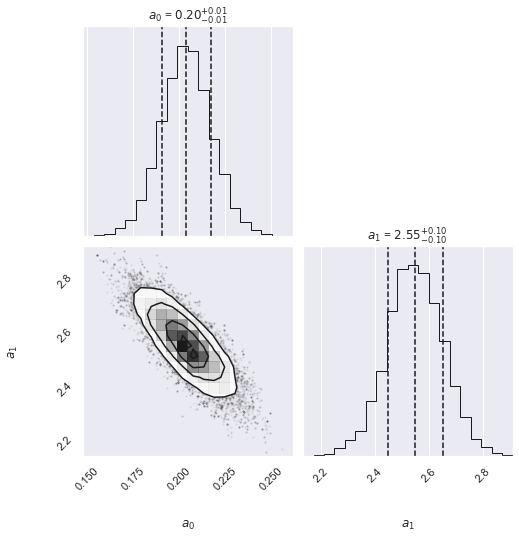

In [17]:
import corner

#use the emcee_trace parameter
fig, ax = plt.subplots(2,2, figsize=(8,8))
corner.corner(emcee_trace.T,labels=[r"$a_{0}$", r"$a_{1}$", r"$a_{2}$", r"$a_{3}$", r"$a_{4}$", r"$a_{5}$", r"$a_{6}$"], quantiles=[0.16, 0.5, 0.84],fig=fig,show_titles=True);

Comparing the values obtained from the Gaussian prior + likelihood above, it is evident that they match well enough with the paper to be considered sufficiently accurate. 

## Adding the Savage-Dickey Density Ratio calculation

#### Started: 20 April 2021

In order to determine the usefulness of extra parameters and test our confidence in our model that we have computed with an MH sampler, we want to use the Savage-Dickey density ratio (SDDR) to easily determine this. The equation is simple and stated below:

$$
B_{01} = \frac{p(\omega|d, M_{1})}{\pi(\omega|M_{1})}|_{\omega = \omega_{*}},
$$

where the numerator is the normalized posterior and the denominator is the prior.

In order to do this, we will pull results from our previous calculation and see what we get for $B_{01}$, also known as the Bayes factor.

***Game plan for this code***

We need the elements listed below for this to work:

- Control over binning in corner plot (set the bins to a specific width so we know we don't have too much spread over the distribution)
    - This can be done using something like the bins option, which sets the number of bins, or the option hist_bin_factor which seems to multiply the bins by a specific number so you could get more of them. I don't see a width yet that I can set.
- Sampling run over the prior for the selected number of coefficents alone, for the exact same number of samples as we did for the posterior
- Division of those two quantities

### Initialisation

In [143]:
#re-define constants for this specific routine
ndim = 6
nwalkers = 50 
nsteps = 20000 

total_samples = nwalkers * nsteps

print('The total number of samples will be {}.'.format(total_samples))

#number of data points
nd = 10 

#order of the polynomial
k = ndim - 1

#dummy number to indicate real value
kreal = 5

print('Using {} walkers with {} steps each.'.format(nwalkers, nsteps))

#initialize the sequence by starting the walkers at a random point
starting_points = np.random.randn(nwalkers, ndim)

The total number of samples will be 1000000.
Using 50 walkers with 20000 steps each.


### Sampling the prior

In [144]:
#import the emcee sampler package
import emcee

In [145]:
#run the sampling over the Gaussian prior
sampler_pr = emcee.EnsembleSampler(nwalkers, ndim, log_gaussprior, args=[k])

#run the sampler and print the wall time
%time sampler_pr.run_mcmc(starting_points, nsteps)
print('Calculation finished!')

Wall time: 19.4 s
Calculation finished!


In [146]:
#reshape and cut burn-in
emcee_trace_pr = sampler_pr.chain[:, :, :].reshape(-1, ndim).T

#burn-in
nburnin = 1000

#throw out the burn-in and reshape again
emcee_trace_pr = sampler_pr.chain[:, nburnin:, :].reshape(-1, ndim).T
emcee_lnprob_pr = sampler_pr.lnprobability[:, nburnin:].reshape(-1).T

#print the coefficients from the maximum of the mode
max_mode_a_pr=max_of_mode(sampler_pr)
with np.printoptions(precision=3):
    print(f'Max prior is at: {max_mode_a_pr}')

Max prior is at: [-0.538  0.442  0.007 -0.364 -0.188 -0.257]


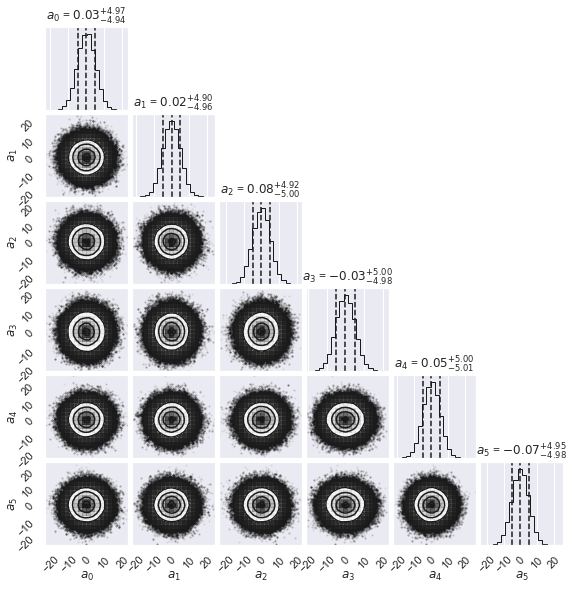

In [147]:
#plot the prior samples
import corner

#use the emcee_trace parameter
fig, ax = plt.subplots(ndim,ndim, figsize=(8,8))
corner.corner(emcee_trace_pr.T,labels=[r"$a_{0}$", r"$a_{1}$", r"$a_{2}$", r"$a_{3}$", r"$a_{4}$", r"$a_{5}$", r"$a_{6}$"], quantiles=[0.16, 0.5, 0.84],fig=fig,show_titles=True);

In [148]:
#make an array of the chain results for a3
pr_result = sampler_pr.chain[:,:,:]

#extract the a3 results
pr_result_a3 = sampler_pr.chain[:,:,k]

### Sampling the posterior

In [149]:
#run the sampler over the Gaussian posterior
sampler_post = emcee.EnsembleSampler(nwalkers, ndim, log_posterior2, args=[x, data, sig, nd, k])

#run the sampler and print the wall time
%time sampler_post.run_mcmc(starting_points, nsteps)
print('Calculation finished!')

Wall time: 1min 41s
Calculation finished!


In [150]:
#reshape and cut burn-in
emcee_trace_post = sampler_post.chain[:, :, :].reshape(-1, ndim).T

#burn-in
nburnin = 1000

#throw out the burn-in and reshape again
emcee_trace_post = sampler_post.chain[:, nburnin:, :].reshape(-1, ndim).T
emcee_lnprob_post = sampler_post.lnprobability[:, nburnin:].reshape(-1).T

#print the coefficients from the maximum of the mode
max_mode_a_post=max_of_mode(sampler_post)
with np.printoptions(precision=3):
    print(f'Max posterior is at: {max_mode_a_post}')

Max posterior is at: [ 0.248  1.627  3.066  0.33  -0.285  0.15 ]


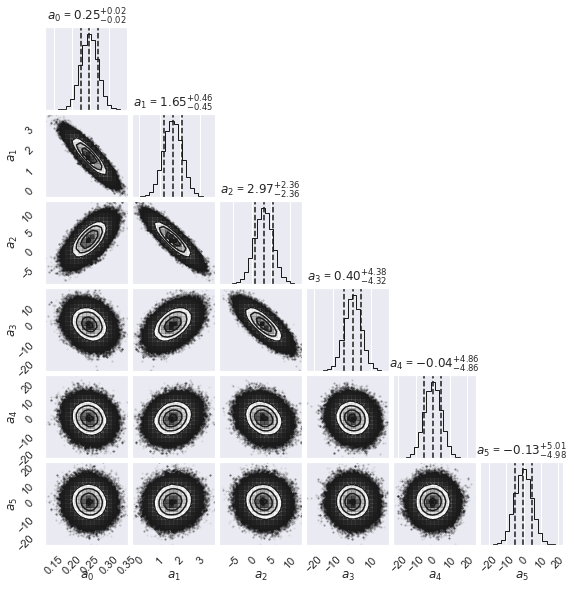

In [151]:
#plot the prior samples
import corner

#use the emcee_trace parameter
fig, ax = plt.subplots(ndim,ndim, figsize=(8,8))
corner.corner(emcee_trace_post.T,labels=[r"$a_{0}$", r"$a_{1}$", r"$a_{2}$", r"$a_{3}$", r"$a_{4}$", r"$a_{5}$", r"$a_{6}$"], quantiles=[0.16, 0.5, 0.84],fig=fig,show_titles=True);

In [152]:
#make an array of the chain results
post_result = sampler_post.chain[:,:,:]

#extract the a3 results
post_result_a3 = sampler_post.chain[:,:,k]

### Plotting the histograms

In [153]:
#bin ranges for BOTH of the distributions
bin_ranges = np.linspace(-25.0, 25.0, 80)

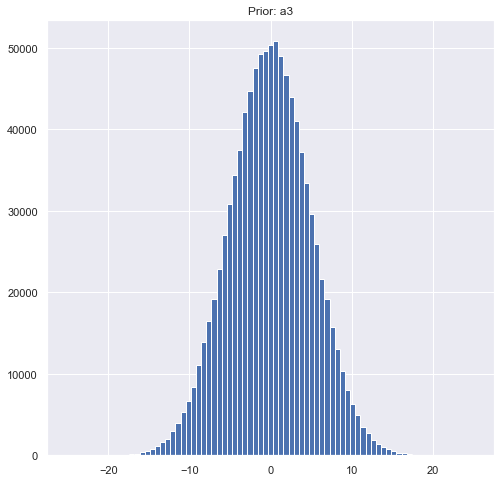

Output:  [0.0000e+00 5.0000e+00 5.0000e+00 1.0000e+00 4.0000e+00 6.0000e+00
 1.0000e+00 1.8000e+01 2.1000e+01 6.4000e+01 9.1000e+01 9.2000e+01
 1.6800e+02 1.6800e+02 3.6500e+02 5.3700e+02 8.0700e+02 1.1010e+03
 1.5810e+03 1.9880e+03 3.0250e+03 3.9250e+03 5.2830e+03 6.6990e+03
 8.4060e+03 1.1087e+04 1.3889e+04 1.6435e+04 1.9135e+04 2.2836e+04
 2.6972e+04 3.0826e+04 3.4333e+04 3.7448e+04 4.2100e+04 4.4641e+04
 4.7512e+04 4.9200e+04 4.9633e+04 5.0374e+04 5.0810e+04 4.8926e+04
 4.6596e+04 4.3937e+04 4.1069e+04 3.7219e+04 3.3350e+04 2.9625e+04
 2.5891e+04 2.1677e+04 1.9123e+04 1.5692e+04 1.3050e+04 1.0333e+04
 8.0290e+03 6.2330e+03 4.9560e+03 3.5070e+03 2.7560e+03 1.8600e+03
 1.4440e+03 9.7700e+02 7.3400e+02 4.9300e+02 3.3000e+02 2.4300e+02
 1.2800e+02 8.8000e+01 6.8000e+01 2.2000e+01 2.4000e+01 1.8000e+01
 3.0000e+00 3.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00]
The autocorrelation information is: p = [ 36.51976166 -27.61266951]; cov = [[ 0.00561267 -0.00493535]
 [-0.

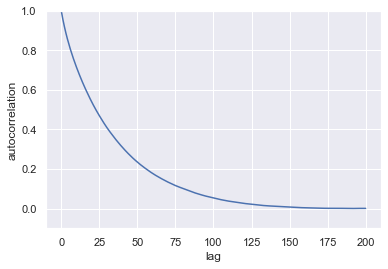

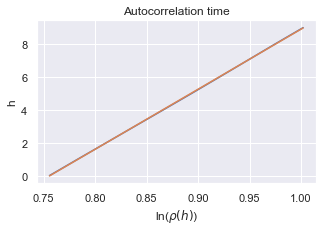

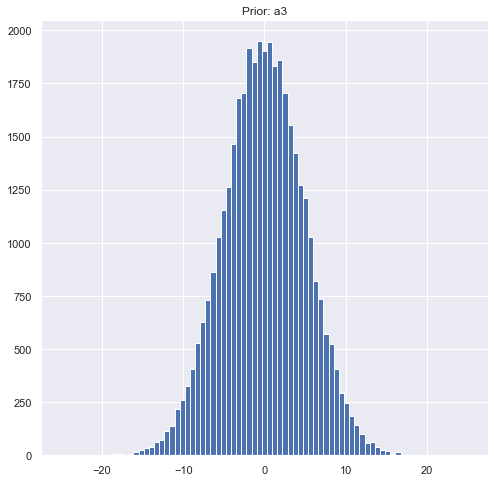

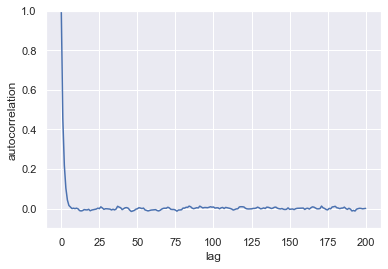

In [154]:
#test a3 by implementing SDDR via a histogram sample counting method
fig, ax = plt.subplots(1,1, figsize=(8,8))

#flatten into a 1d array
pr_data = pr_result_a3.flatten()

#plot the histogram
pr_npoints, pr_rbins, pr_patches = ax.hist(pr_data, bins = bin_ranges)
ax.set_title('Prior: a3')
plt.show()

print('Output: ', pr_npoints)

#plot the autocorrelation
pr_acors = autocorrelation(pr_data, max_lag=200)
fig, ax = plt.subplots()
ax.plot(pr_acors);
ax.set(xlabel='lag', ylabel='autocorrelation', ylim=(-.1, 1));

#determine the autocorrelation time
pr_rho = pr_acors[25:35]

fig = plt.figure(figsize=(5,3))
pr_y = np.arange(10)
pr_x = -np.log(pr_rho)
        
plt.xlabel(r'ln($\rho(h)$)')
plt.ylabel('h')
plt.title('Autocorrelation time')
plt.plot(pr_x, pr_y)

#linear fit
p, cov = np.polyfit(pr_x, pr_y, 1, cov = True)
print('The autocorrelation information is: p = {}; cov = {}'.format(p, cov))
plt.plot(pr_x, p[0]*pr_x + p[1])

#adjust the samples by thinning according to the autocorrelation time
pr_data_thin = []
print(len(pr_data))
for i in range(len(pr_data)):
    if i % 26 == 0:
        pr_data_thin.append(pr_data[i])

#array thinned samples
pr_data_thin = np.array(pr_data_thin)

#re-draw the histogram with thinned samples
fig, ax1 = plt.subplots(1,1, figsize=(8,8))    
pr_npoints_thin, pr_rbins_thin, pr_patches_thin = ax1.hist(pr_data_thin, bins = bin_ranges)
ax1.set_title('Prior: a3')
plt.show()

#re-draw the autocorrelation function
pr_thin_acors = autocorrelation(pr_data_thin, max_lag=200)
fig, ax2 = plt.subplots()
ax2.plot(pr_thin_acors);
ax2.set(xlabel='lag', ylabel='autocorrelation', ylim=(-.1, 1));

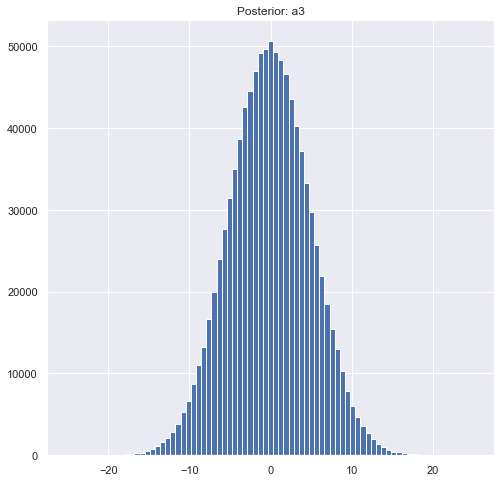

Output:  [1.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 8.0000e+00
 1.0000e+01 1.7000e+01 3.5000e+01 3.1000e+01 5.6000e+01 1.0100e+02
 1.6600e+02 2.3000e+02 3.0300e+02 5.6200e+02 7.1500e+02 1.1050e+03
 1.5900e+03 2.0550e+03 2.8740e+03 3.8740e+03 5.2660e+03 6.6280e+03
 8.6580e+03 1.1060e+04 1.3263e+04 1.6620e+04 1.9967e+04 2.3985e+04
 2.7628e+04 3.1482e+04 3.5032e+04 3.8615e+04 4.2520e+04 4.4519e+04
 4.6943e+04 4.9187e+04 4.9664e+04 5.0627e+04 4.9241e+04 4.8349e+04
 4.6570e+04 4.3569e+04 4.0311e+04 3.7167e+04 3.3325e+04 2.9784e+04
 2.5699e+04 2.1907e+04 1.8497e+04 1.5432e+04 1.2969e+04 1.0270e+04
 7.8640e+03 5.9680e+03 4.6830e+03 3.5920e+03 2.6890e+03 2.0490e+03
 1.4130e+03 1.0100e+03 6.7800e+02 4.5700e+02 4.2100e+02 2.3200e+02
 1.6000e+02 1.3100e+02 7.9000e+01 3.0000e+01 7.0000e+00 2.2000e+01
 1.0000e+01 4.0000e+00 1.0000e+00 1.1000e+01 1.0000e+00 0.0000e+00
 0.0000e+00]
The autocorrelation information is: p = [ 36.36145777 -27.18771064]; cov = [[ 0.0004065  -0.00035425]
 [-0.

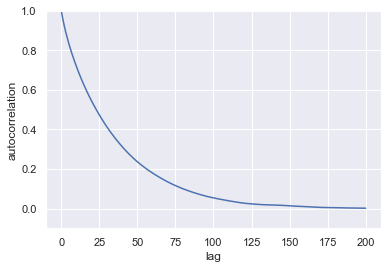

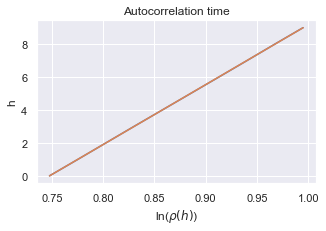

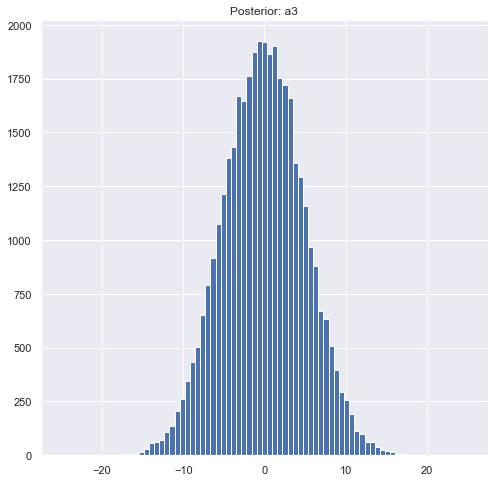

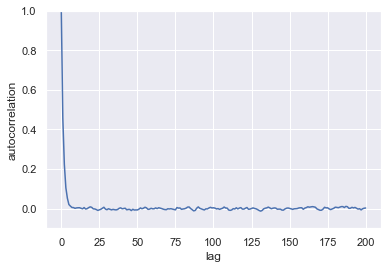

In [155]:
#test a3 by implementing SDDR via a histogram sample counting method
fig, ax = plt.subplots(1,1, figsize=(8,8))

#flatten into a 1d array
post_data = post_result_a3.flatten()

#plot the histogram
post_npoints, post_rbins, post_patches = ax.hist(post_data, bins = bin_ranges)
ax.set_title('Posterior: a3')
plt.show()

print('Output: ', post_npoints)

#plot the autocorrelation
post_acors = autocorrelation(post_data, max_lag=200)
fig, ax = plt.subplots()
ax.plot(post_acors);
ax.set(xlabel='lag', ylabel='autocorrelation', ylim=(-.1, 1));

#determine the autocorrelation time
post_rho = post_acors[25:35]

fig = plt.figure(figsize=(5,3))
post_y = np.arange(10)
post_x = -np.log(post_rho)
        
plt.xlabel(r'ln($\rho(h)$)')
plt.ylabel('h')
plt.title('Autocorrelation time')
plt.plot(post_x, post_y)

#linear fit
p, cov = np.polyfit(post_x, post_y, 1, cov = True)
print('The autocorrelation information is: p = {}; cov = {}'.format(p, cov))
plt.plot(post_x, p[0]*post_x + p[1])

#adjust the samples by thinning according to the autocorrelation time
post_data_thin = []
print(len(post_data))
for i in range(len(post_data)):
    if i % 26 == 0:
        post_data_thin.append(post_data[i])

#array thinned samples
post_data_thin = np.array(post_data_thin)
print(len(post_data_thin))

#re-draw the histogram with thinned samples
fig, ax1 = plt.subplots(1,1, figsize=(8,8))    
post_npoints_thin, post_rbins_thin, post_patches_thin = ax1.hist(post_data_thin, bins = bin_ranges)
ax1.set_title('Posterior: a3')
plt.show()

#re-draw the autocorrelation function
post_thin_acors = autocorrelation(post_data_thin, max_lag=200)
fig, ax2 = plt.subplots()
ax2.plot(post_thin_acors);
ax2.set(xlabel='lag', ylabel='autocorrelation', ylim=(-.1, 1));

Now we want to see which bin is the central one, and how many samples it contains, for both of these plots.

In [156]:
#index of central bin
index = int(len(bin_ranges)/2 - 1)
print('Index of bin edge: {}'.format(index))
print(bin_ranges)

#extract number of samples in the bin in the posterior and prior
post_samples = post_npoints[index]
pr_samples = pr_npoints[index]
print('\nNumber of posterior samples: {}'.format(post_samples))
print('\nNumber of prior samples: {}'.format(pr_samples))

#extract number of samples in the bin in the posterior and prior (thinned)
post_samples_thin = post_npoints_thin[index]
pr_samples_thin = pr_npoints_thin[index]
print('\nNumber of thinned posterior samples: {}'.format(post_samples_thin))
print('\nNumber of thinned prior samples: {}'.format(pr_samples_thin))

#statistical error of distributions
error_pr = np.sqrt(pr_samples)
error_post = np.sqrt(post_samples)

#statistical error of distributions (thinned)
error_pr_thin = np.sqrt(pr_samples_thin)
error_post_thin = np.sqrt(post_samples_thin)

#print the errors out
print('\nStatistical error on the posterior samples: ', error_post)
print('\nStatistical error on the prior samples: ', error_pr)

#print the errors out (thinned)
print('\nStatistical error on the thinned posterior samples: ', error_post_thin)
print('\nStatistical error on the thinned prior samples: ', error_pr_thin)

Index of bin edge: 39
[-25.         -24.36708861 -23.73417722 -23.10126582 -22.46835443
 -21.83544304 -21.20253165 -20.56962025 -19.93670886 -19.30379747
 -18.67088608 -18.03797468 -17.40506329 -16.7721519  -16.13924051
 -15.50632911 -14.87341772 -14.24050633 -13.60759494 -12.97468354
 -12.34177215 -11.70886076 -11.07594937 -10.44303797  -9.81012658
  -9.17721519  -8.5443038   -7.91139241  -7.27848101  -6.64556962
  -6.01265823  -5.37974684  -4.74683544  -4.11392405  -3.48101266
  -2.84810127  -2.21518987  -1.58227848  -0.94936709  -0.3164557
   0.3164557    0.94936709   1.58227848   2.21518987   2.84810127
   3.48101266   4.11392405   4.74683544   5.37974684   6.01265823
   6.64556962   7.27848101   7.91139241   8.5443038    9.17721519
   9.81012658  10.44303797  11.07594937  11.70886076  12.34177215
  12.97468354  13.60759494  14.24050633  14.87341772  15.50632911
  16.13924051  16.7721519   17.40506329  18.03797468  18.67088608
  19.30379747  19.93670886  20.56962025  21.20253165  2

In [157]:
#divide to get the SDDR ratio
sddr = post_samples / pr_samples

#sddr, thinned 
sddr_thin = post_samples_thin / pr_samples_thin

#print the SDDR results
print('The SDDR for a{} is: {}'.format(k, sddr))
print('\nThe thinned SDDR for a{} is: {}'.format(k, sddr_thin))

#statistical error propagation
error_prop = sddr * np.sqrt((error_post/post_samples)**2 + (error_pr/pr_samples)**2)
error_prop_thin = sddr_thin * np.sqrt((error_post_thin/post_samples_thin)**2 + (error_pr_thin/pr_samples_thin)**2)

#print the error propagation result
print('\nThe statistical error is: {}'.format(error_prop))
print('\nThe thinned statistical error is: {}'.format(error_prop_thin))

The SDDR for a5 is: 1.0050224322070909

The thinned SDDR for a5 is: 1.0084033613445378

The statistical error is: 0.006324763296038368

The thinned statistical error is: 0.03261438098307863


Below we render a table of tested samples, bins, and bin ranges.

Accepted value from the analytical calculation (Wesolowski et al. 2016): 1.137931

| Trial # | Number of samples | Number of bins | Bin width | Edges | SDDR result | Statistical error |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| 1 | 1 000 000 | 50 | 1.02 | -25.0, 25.0 | 1.131317 | 0.005427 |
| 2 | 1 000 000 | 52 | 1.00 | -25.5, 25.5 | 1.132050 | 0.005487 |
| 3 | 1 000 000 | 60 | 0.847 | -25.0, 25.0 | 1.136409 | 0.005986 |
| 4 | 1 000 000 | 70 | 0.725 | -25.0, 25.0 | 1.136418 | 0.006473 |
| 5 | 1 000 000 | 80 | 0.633 | -25.0, 25.0 | 1.137408 | 0.006939 |
| 6 | 1 000 000 | 100 | 0.505 | -25.0, 25.0 | 1.146043 | 0.007824 |
| 7 | 1 000 000 | 40 | 1.28 | -25.0, 25.0 | 1.126372 | 0.004825 |
| 8 | 1 000 000 | 46 | 1.11 | -25.0, 25.0 | 1.131761 | 0.005206 |
| 9 | 1 000 000 | 40 | 1.31 | -25.5, 25.5 | 1.125664 | 0.004776 |
| 10 | 1 000 000 | 20 | 2.63 | -25.0, 25.0 | 1.126562 | 0.003386 |
| 11 | 1 000 000 | 26 | 2.00 | -25.0, 25.0 | 1.129381 | 0.003881 |
| 12 | 1 000 000 | 30 | 1.72 | -25.0, 25.0 | 1.132948 | 0.004191 |
| 13 | 1 000 000 | 16 | 3.33 | -25.0, 25.0 | 1.126388 | 0.003022 |
| 14 | 1 000 000 | 10 | 5.56 | -25.0, 25.0 | 1.117407 | 0.002362 |
| 15 | 1 000 000 | 6 | 10.0 | -25.0, 25.0 | 1.089527 | 0.001824 |
| 16 | 1 000 000 | 4 | 16.7 | -25.0, 25.0 | 1.040164 | 0.001530 |

Below, a table of SDDR values and statistical errors for 16 runs of the same bin range, width, and number of samples.

- Samples: 1 000 000
- Bin width: 0.633
- Bin edges: -25.0, 25.0
- Bin number: 80

| Trial # | SDDR result | Statistical error |
| :-: | :-: | :-: |
| 1 | 1.158118 | 0.007015 |
| 2 | 1.158117 | 0.007015 | 
| 3 | 1.158118 | 0.007015 |
| 4 | 1.158118 | 0.007015 |
| 5 | 1.158118 | 0.007015 |
| 6 | 1.158118 | 0.007015 |
| 7 | 1.161098 | 0.007058 |
| 8 | 1.130415 | 0.006883 |
| 9 | 1.134450 | 0.006907 |
| 10 | 1.158105 | 0.007008 |
| 11 | 1.131262 | 0.006907 |
| 12 | 1.129302 | 0.006923 |
| 13 | 1.136631 | 0.006929 | 
| 14 | 1.135376 | 0.006926 |
| 15 | 1.159048 | 0.007049 |

In [50]:
mean = (1.158118 + 1.161098 + 1.130415 + 1.134450 + 1.158105 + 1.131262 + 1.129302 + 1.136631 + 1.135376 + 1.159048)/10
print('The mean of the 10 fluctuating trials is: {}'.format(mean))

The mean of the 10 fluctuating trials is: 1.1433804999999997


Below, a table of SDDR values and statistical errors for 10 runs of the same bin range, width, and number of samples, but with the thinning implemented. 

- Samples: 1 000 000 ; thinned samples: 38 462
- Bin width: 0.633
- Bin edges: -25.0, 25.0
- Bin number: 80

| Trial # | SDDR result | Statistical error |
| :-: | :-: | :-: |
| 1 | 1.102051 | 0.034042 |
| 2 | 1.085341 | 0.033708 | 
| 3 | 1.131080 | 0.035131 |
| 4 | 1.161821 | 0.037118 |
| 5 | 1.055284 | 0.032575 |
| 6 | 1.154799 | 0.035833 |
| 7 | 1.189434 | 0.037278 |
| 8 | 1.240021 | 0.038448 |
| 9 | 1.141822 | 0.035578 |
| 10 | 1.175540 | 0.036717 |

Below, a table of SDDR values and statistical errors for 10 runs of the same bin range, width, and number of samples, but with the thinning implemented. 

- Samples: 1 000 000 ; thinned samples: 38 462
- Bin width: 0.633
- Bin edges: -25.0, 25.0
- Bin number: 80

| Trial # | SDDR result | Statistical error | Posterior $N_{post}$ | Posterior fluctuation $\sqrt{N_{post}}$ | Prior $N_{pr}$ | Prior fluctuation $\sqrt{N_{pr}}$ |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| 1 | 1.122544 | 0.035010 | 2171.0 | 46.6 | 1934.0 | 44.0 |
| 2 | 1.140887 | 0.034687 | 2316.0 | 48.1 | 2030.0 | 45.1 |
| 3 | 1.116016 | 0.034818 | 2174.0 | 46.6 | 1948.0 | 44.1 |
| 4 | 1.187141 | 0.036841 | 2271.0 | 47.7 | 1913.0 | 43.7 |
| 5 | 1.129179 | 0.034899 | 2229.0 | 47.2 | 1974.0 | 44.4 |
| 6 | 1.170836 | 0.036779 | 2200.0 | 46.9 | 1879.0 | 43.3 |
| 7 | 1.158084 | 0.035874 | 2249.0 | 47.4 | 1942.0 | 44.1 |
| 8 | 1.176225 | 0.036532 | 2256.0 | 47.5 | 1918.0 | 43.8 |
| 9 | 1.227616 | 0.038406 | 2276.0 | 47.7 | 1854.0 | 43.1 |
| 10 | 1.107724 | 0.034444 | 2180.0 | 46.7 | 1968.0 | 44.4 |

In [158]:
print('a3 results: ')

#mean of the above values
a3_values = [1.122544, 1.140887, 1.116016, 1.187141, 1.129179, 1.170836, 1.158084, 1.176225, 1.227616, 1.107724]
print(np.mean(a3_values))

#standard deviation of the above values
print(np.std(a3_values))

print('\na2 results: ')

#mean
a2_values = [0.209636, 0.198947, 0.192956, 0.195122, 0.203416, 0.188500, 0.216161, 0.207254, 0.186864, 0.188064]
print(np.mean(a2_values))

#standard deviation
print(np.std(a2_values))

print('\na4 results: ')

#mean
a4_values = [1.038855, 1.011840, 1.021180, 1.069634, 0.974671, 1.035604, 1.028571, 1.036923, 1.052576, 1.039196]
print(np.mean(a4_values))

#standard deviation
print(np.std(a4_values))

print('\na5 results: ')

#mean
a5_values = [0.989198, 1.016880, 1.023859, 1.013804, 1.032291, 0.971532, 1.015057, 0.957086, 1.034914, 1.008403]
print(np.mean(a5_values))

#standard deviation
print(np.std(a5_values))

a3 results: 
1.1536251999999998
0.03559786839348675

a2 results: 
0.198692
0.009607317887943542

a4 results: 
1.0309050000000002
0.024053207582357912

a5 results: 
1.0063024
0.024444376855219697


Now we can do this ratio and error analysis for all of the coefficients: 0 to 1, 1 to 2, 2 to 3, 3 to 4, 4 to 5, etc. 

Results for the runs may now be written in a table.

| Comparison | SDDR mean result | Standard deviation |
| :-: | :-: | :-: |
| $a_{1}$ to $a_{2}$ | 0.198692 | 0.009607 |
| $a_{2}$ to $a_{3}$ | 1.153625 | 0.035598 |
| $a_{3}$ to $a_{4}$ | 1.030905 | 0.024053 |
| $a_{4}$ to $a_{5}$ | 1.006302 | 0.024444 |